## Importe

In [1]:
import pandas as pd
import numpy as np

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sns
import jupyter_black

In [2]:
# Run Black for Better Formatting
jupyter_black.load()

In [3]:
# Display all columns
pd.set_option("display.max_columns", None)

In [4]:
# Importing File
fifa = (
    pd.read_csv("players_fifa23.csv")
    .drop_duplicates(subset=["FullName", "Club"])
    .reset_index()
)

## Data Cleaning

In [67]:
# Setting Full Name as Index
fifa2 = fifa.drop_duplicates(subset=["FullName"]).set_index("FullName")

In [69]:
# Selection of numeric attributes that are useful for player recommendation
fifa3 = fifa2._get_numeric_data()
fifa4 = fifa3.drop(
    [
        "index",
        "ID",
        "Growth",
        "TotalStats",
        "BaseStats",
        "ValueEUR",
        "WageEUR",
        "ReleaseClause",
        "ContractUntil",
        "ClubNumber",
        "ClubJoined",
        "OnLoad",
        "NationalNumber",
        "IntReputation",
        "GKDiving",
        "GKHandling",
        "GKKicking",
        "GKPositioning",
        "GKReflexes",
        "STRating",
        "LWRating",
        "LFRating",
        "CFRating",
        "RFRating",
        "RWRating",
        "CAMRating",
        "LMRating",
        "CMRating",
        "RMRating",
        "LWBRating",
        "CDMRating",
        "RWBRating",
        "LBRating",
        "CBRating",
        "RBRating",
        "GKRating",
    ],
    axis=1,
)

In [70]:
# Minmax Scaling
scaler = MinMaxScaler()

fifa5 = pd.DataFrame(
    scaler.fit_transform(fifa4), columns=fifa4.columns, index=fifa4.index
)

In [71]:
# Weighting: Overall-Skill & Potential should get a higher weight
fifa5["Overall"] = fifa5["Overall"] * 4
fifa5["Potential"] = fifa5["Potential"] * 2

## Recommendation System

In [72]:
# Instanciating of KNN and Fitting with Dataset
knn = NearestNeighbors(metric="cosine")
knn.fit(fifa5)

NearestNeighbors(metric='cosine')

In [73]:
# Calculation of Distance and Rank with KNN
distance, rank = knn.kneighbors(fifa5, 11)

In [74]:
# Buiding a Dict with Player Index and Player Name
id_name = fifa["FullName"].to_dict()

In [75]:
# Column with Player Name and Club
id_name_club = fifa[["FullName", "Club"]].drop_duplicates()
id_name_club["Name and Club"] = (
    id_name_club.FullName + " " + "(" + id_name_club.Club + ")"
)
id_name_club = id_name_club["Name and Club"].to_dict()

In [76]:
# Building a DataFrame with the Distances between Players
dist_df = pd.DataFrame(
    columns=[f"rank_{i}" for i in range(1, 11)],
    index=fifa5.index,
    data=distance[:, 1:],
)

In [77]:
# Building a DataFrame with Indices of similar Players and mapping it to Players id_name
similar_df = pd.DataFrame(
    columns=[f"rank_{i}_name" for i in range(1, 11)],
    index=fifa5.index,
    data=rank[:, 1:],
).apply(lambda x: x.map(id_name))

In [78]:
# Building a DataFrame with Indices of similar Players and mapping it to Players id_name with Club
similar_with_club_df = pd.DataFrame(
    columns=[f"rank_{i}_name_club" for i in range(1, 11)],
    index=fifa5.index,
    data=rank[:, 1:],
).apply(lambda x: x.map(id_name_club))

In [79]:
# Joining the different DataFrames together
df_data = fifa4.join(similar_df).join(dist_df).join(similar_with_club_df)

In [80]:
# Droping rows with Nans
df_data = df_data.dropna(how="any")

In [81]:
def similar_player(player_name):
    player_name = df_data[df_data.index == player_name].index[0]

    ## Bar chart
    plt.figure(figsize=(12, 6))

    Xaxis = df_data.loc[player_name].values[-20:-10]
    Yaxis = df_data.loc[player_name].values[-10:]

    fig = sns.barplot(data=df_data, x=Xaxis, y=Yaxis, palette="mako")
    fig.set_title('Players similar to  " ' + str(player_name) + ' "')
    plt.show()

    ## Table display

    display_df = pd.concat(
        [
            df_data[df_data.index == player_name],
            df_data.loc[df_data.loc[player_name].values[42:52]],
        ]
    ).iloc[:, :42]

    display(display_df)

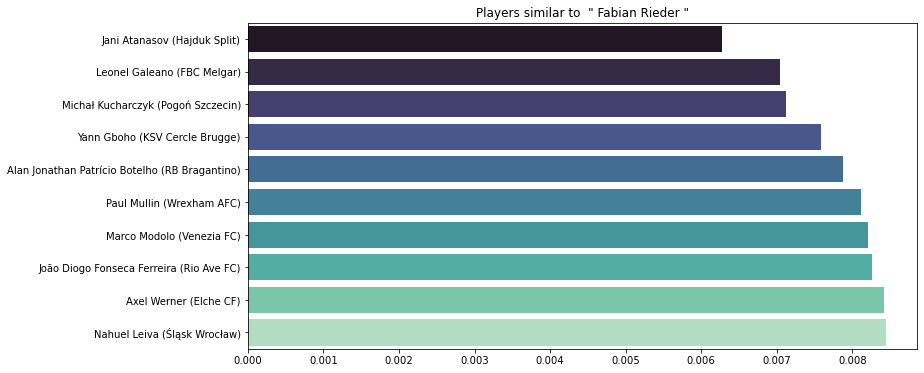

,Age,Height,Weight,Overall,Potential,WeakFoot,SkillMoves,PaceTotal,ShootingTotal,PassingTotal,DribblingTotal,DefendingTotal,PhysicalityTotal,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
FullName,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Fabian Rieder,20,179,74,68,83,3,2,69,61,69,70,50,61,54,58,41,74,42,70,68,72,72,72,70,68,70,52,83,68,62,74,59,65,50,52,63,73,51,70,45,55,53
Jani Atanasov,22,184,77,69,76,3,2,71,62,71,67,63,71,64,53,63,73,47,66,68,76,72,73,68,73,60,67,55,72,59,70,73,81,68,68,63,71,48,58,58,65,58
Leonel Galeano,30,183,84,68,68,3,2,52,35,58,57,69,70,51,25,68,66,31,55,50,35,64,60,50,53,54,66,52,47,70,66,70,37,74,69,55,54,47,60,72,69,63
Michał Kucharczyk,31,178,72,67,67,3,3,78,64,61,69,42,66,63,65,62,65,61,67,55,59,46,65,80,77,83,66,75,67,78,65,64,60,69,48,67,64,65,70,49,28,32
Yann Gboho,21,178,64,67,76,2,3,76,61,63,74,35,55,62,61,50,65,59,75,61,53,59,72,79,74,81,65,77,64,45,65,52,56,50,30,63,64,60,62,34,36,34
Alan Jonathan Patrício Botelho,22,180,73,69,69,3,2,61,46,55,62,72,67,36,42,70,71,32,60,32,30,66,62,66,56,69,60,67,56,81,71,65,51,64,74,42,50,48,64,70,73,75
Paul Mullin,27,178,71,67,68,3,3,75,68,56,66,38,72,55,69,64,58,61,65,64,59,47,65,73,77,71,67,76,70,84,81,71,66,58,29,68,55,63,68,42,35,27
Marco Modolo,33,186,82,69,69,4,2,59,45,49,48,68,79,40,42,76,62,41,40,22,26,58,52,52,65,57,63,50,61,84,73,86,41,68,63,40,42,38,62,66,70,65
João Diogo Fonseca Ferreira,21,185,79,69,79,3,2,78,42,55,63,64,67,64,31,52,63,46,62,53,32,46,65,77,78,56,68,60,69,65,70,67,35,65,67,53,47,44,63,62,68,67


In [82]:
similar_player("Fabian Rieder")

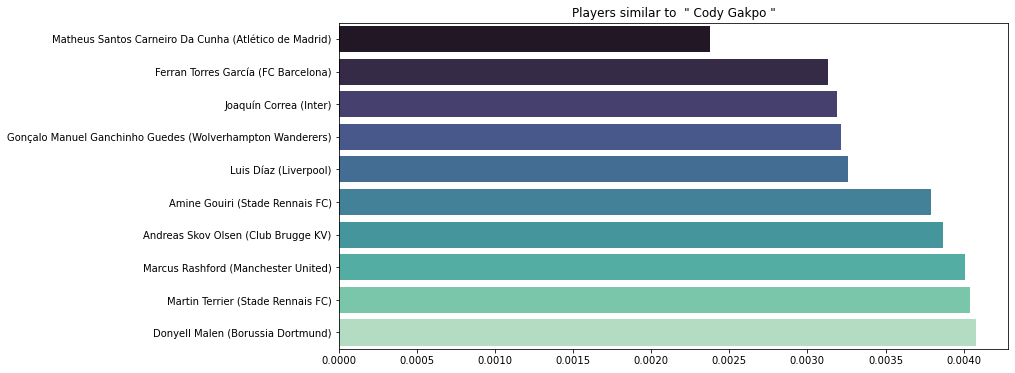

,Age,Height,Weight,Overall,Potential,WeakFoot,SkillMoves,PaceTotal,ShootingTotal,PassingTotal,DribblingTotal,DefendingTotal,PhysicalityTotal,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
FullName,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Cody Gakpo,23,189,76,83,87,4,4,87,82,77,84,41,74,83,82,60,76,75,86,78,76,68,84,86,87,81,81,71,86,75,79,77,83,60,39,81,79,68,78,43,38,28
Matheus Santos Carneiro Da Cunha,23,184,75,81,86,4,4,84,82,75,84,32,74,75,84,65,78,75,86,77,64,67,84,81,86,85,82,70,83,74,81,72,82,68,24,83,77,74,82,29,28,32
Ferran Torres García,22,184,77,82,88,4,4,84,79,79,83,35,67,79,80,75,81,74,84,76,60,78,84,87,81,83,82,78,79,75,73,69,76,54,34,86,82,74,82,35,24,28
Joaquín Correa,27,189,75,80,80,4,4,84,75,76,84,39,69,74,77,67,77,75,87,81,63,74,86,80,87,83,77,67,79,63,76,74,71,48,36,78,80,57,73,39,37,26
Gonçalo Manuel Ganchinho Guedes,25,179,68,82,85,4,4,86,83,74,83,38,70,81,82,75,70,75,84,76,70,69,82,85,87,84,81,75,87,63,72,72,88,64,50,79,76,69,78,24,34,30
Luis Díaz,25,180,73,84,87,4,4,91,80,75,87,34,73,76,80,62,76,74,89,75,58,71,87,92,91,88,83,75,84,73,84,69,82,70,25,81,77,63,83,28,38,34
Amine Gouiri,22,181,83,79,86,3,4,78,81,76,80,45,69,76,81,68,79,78,82,78,76,69,80,81,75,76,77,72,81,69,72,71,82,61,44,82,76,78,78,45,41,32
Andreas Skov Olsen,22,188,75,76,83,4,4,86,74,69,76,39,68,74,73,64,70,75,78,70,62,65,78,90,82,70,66,74,77,69,73,67,74,62,34,74,68,68,68,39,37,31
Marcus Rashford,24,186,70,81,85,3,5,87,82,75,81,41,71,75,81,68,76,73,83,82,76,70,81,83,90,82,80,74,92,74,72,71,78,69,39,78,76,85,75,40,38,33


In [83]:
similar_player("Cody Gakpo")